# Simulating a simple Credit Portfolio Model with Python

The biggest risk most banks and financial institutions face is credit risk, i.e. the potential losses caused by obligors defaulting on their debt. A certain amount of loss due to credit risk has to be regarded as ordinary part of conducting banking business. The loss that will occur on average over a given time period (usually one year) is labeld **Expected Loss** (EL) and is priced into the credit conditions. It is one of the most fundamental measures of credit risk. It is usually straight forward to calculated the expected loss of a credit portfolio - provided one has reliable estimates of the risk parameters involved. 


A more crucial metric for the survival of a financial company is the **Unexpected Loss** (UL). One can think of the UL in rough terms as unusually high portfolio losses with the potential to wipe-out a financial institute. This often due to a much higher than average number of defaults due to underlying common economic factors as could be seen during the financial crisis of 2007–2008. In order to quantify such potentially devastating tail risks, risk managers employ credit risk models to simulate the entire portfolio loss distribution and assess the magnitude of losses for the worst realizations.


In this notebook, we will implement a simple simulation based credit portfolio model in Python. The notebook is inspired by a workshop on credit portfolio models by [Risk Research](http://www.risk-research.de/de/startseite/) and draws heavily from the [book by de Servigny and Renault](https://www.amazon.com/Standard-Poors-Measuring-Managing-Credit/dp/0071417559) as well as a review paper by [Peter Albrecht](http://www.risk-insurance.de/Invited_Papers/166/AlbrechtKreditrisiken.pdf).

### Expected Loss of the Credit Portfolio:

The loss due to credit risk for a single creditor $i$ can be written as 

$$L_i = EAD_i \cdot LGD_i \cdot D_i $$

Here, $EAD_i$ denotes the "**Exposure at Default**", i.e. the outstanding credit amount for the defaulting creditor and $LGD_i$ is the "**Loss Given Default**" - the percentage of the exposure which is expected to be lost in the event of an default. In this notebook we will treat these factors as given because we want to focus on the effect of the default dependencies on the overall loss distribution. 

Instead, we will focus on the default indicator $D_i$:

$$D_i= \begin{cases} 1\text{, if debtor i defaults}\\ 0\text{, otherwise}\end{cases}$$

By treating $EAD_i$ and $LGD_i$ as deterministic, we can write the expected loss for obligor $i$ as:

$$EL_i = E[L_i] = EAD_i \cdot LGD_i \cdot E[D_i]$$

The expected value of the default indicator is usually denoted as "**Probability of Default**" (PD): 

$$E[D_i] = \mathbb{P}(D_i=1) = PD_i$$ 

Thus, the expected loss becomes $EL_i = EAD_i \cdot LGD_i \cdot PD_i$.

Finally, the expected loss of the entire credit portfolio is just the sum of the exptected losses of all individual creditors:

$$EL =\sum_{i=1}^N EAD_i \cdot LGD_i \cdot PD_i $$


### Base Case & Binomial Distribution:
Let us consider the most basic example: a portfolio with independent and identical obligors where it is assumed for simplicity's sake that $EAD_i=1$ and $LGD_i=100\%$ $\forall i$. If we assume a homogeneous PD of 5% , the expected loss for each borrower becomes $EL_i = 1 \cdot 100\% \cdot 5\% = 0.05$. The expected portfolio loss is then simply $EL =\sum_{i=1}^N EL_i = N \cdot EL_i = N \cdot 0.05$.

The loss distribution for this portfolio can be estimated quite easily. The binary default-events are distributed according to a Bernoulli-distribution: $D_i \sim \operatorname{Bern} \left({p}\right)$ where $PD=p$. The sum of independent Bernoulli-distributed variables follows a Binomial-distribution: $D = \sum_{i=1}^N D_i \sim \operatorname{B}(N,p)$. As it is assumed in this case that the potential loss is 1 for all creditors ($EAD_i \cdot LGD_i=1$ $\forall i$), it follows that the loss distribution follows a Binomial-distribution as well ($L \sim \operatorname{B}(N,p)$).

In [1]:
#Module Import & Display Settings:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import scipy 
import scipy.stats as stats
from scipy.stats import norm
from scipy.stats import binom

pd.options.display.float_format = '{:.2f}'.format
plt.figure(figsize=(20, 10))
%matplotlib inline

Let's first take a look at very small portfolios - with N being equal to 1, 2, 5 and 10, respectively.
    
The probability mass function of the Binomial-distribution, i.e. the probability that in a portfolio of $N$ creditors with $PD=p$ exactly $k$ defaults will occur is given by:
$\mathbb{P}(\sum_{i=1}^N D_i = k)  =  \binom{N}{k} p^k (1-p)^{N-k}$ 

We can calculate these probability by the Scipy function `scipy.stats.binom.pmf`:

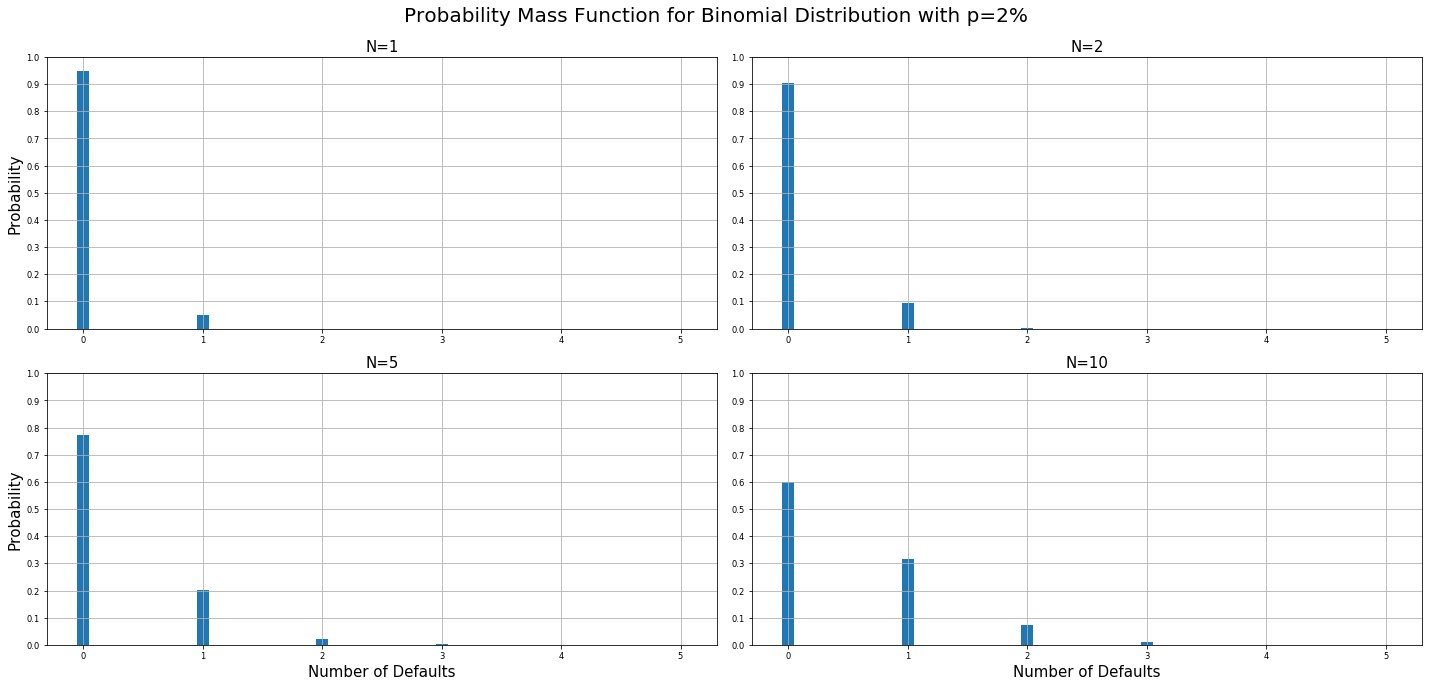

In [2]:
plt.figure(figsize=(20, 10))

p=0.05
x= np.arange(6)

def PMF_Plot(n,p):
    #plt.title('Binomial: N=%i , p=%.2f' % (n,p),fontsize=15)
    plt.title('N=%i' % (n),fontsize=15)
    plt.xticks(x, rotation=0, size='small')
    plt.ylim((0, 1))
    plt.yticks(scipy.linspace(0,1,11),size='small')
    plt.grid(True)
    plt.bar(x,binom.pmf(x,n,p), 0.1)

plt.subplot(221)
PMF_Plot(1,p)
plt.ylabel('Probability',fontsize=15)

plt.subplot(222)
PMF_Plot(2,p)

plt.subplot(223)
PMF_Plot(5,p)
plt.ylabel('Probability',fontsize=15)
plt.xlabel('Number of Defaults',fontsize=15)

plt.subplot(224)
PMF_Plot(10,p)
plt.xlabel('Number of Defaults',fontsize=15)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.suptitle('Probability Mass Function for Binomial Distribution with p=2%',fontsize=20)

For small numbers of $N$ and $p$ the distribution is obviously quite skewed as it get's squeezed against the lower bound of 0 as most creditors never default.

As N becomes larger the Binomial distribution becomes less skewed and takes on a typical bell-shape. In fact, for very large N (and p not to close to either 0 or 1) the Binomial distribution can be approximated reasonably well by the Normal distribution.

We can visualize this with a portfolio consisting of 1,000 creditors:

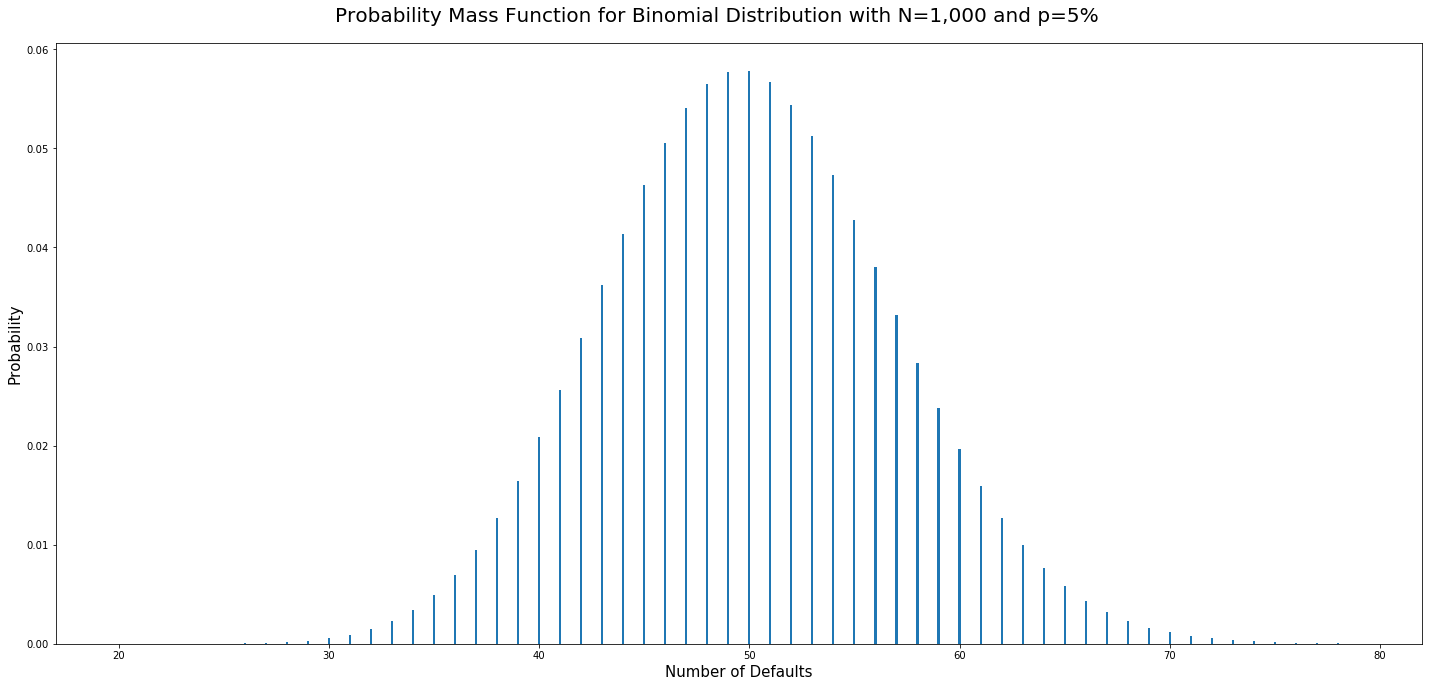

In [3]:
plt.figure(figsize=(20, 10))

p=0.05
x= np.arange(20,80)

plt.bar(x,binom.pmf(x,1000,0.05), 0.1)   

plt.ylabel('Probability',fontsize=15)
plt.xlabel('Number of Defaults',fontsize=15)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.suptitle('Probability Mass Function for Binomial Distribution with N=1,000 and p=5%',fontsize=20)

We already know from the considerations above, what the mean of this portfolio will be. In general, it is quite easy to calculated the first two moments of a binomial distributed variable $L \sim \operatorname{B}(N,p)$.
The mean of the distribution is given by $E[L] = N \cdot p$ and it's variance is $Var[L] = N \cdot p \cdot (1-p)$. 

Thus, in this hypothetical portfolio of 1,000 identical obligors with a $PD=5\%$, this results in $E[L] = 1,000 \cdot 0.05 = 50$ and $Var[L] = 1,000 \cdot 0.05 \cdot 0.95 = 47.5$

We can verify this via `scipy.stats.binom.stats`:

In [4]:
binom_stats = stats.binom.stats(n=1000, p=0.05)
binom_stats[0].item()
"Binomial distribution with N=1,000 and PD=5%. Mean:{0:6.2f}, Variance:{1:6.2f}".format(binom_stats[0].item(),
                                                                                      binom_stats[1].item())

'Binomial distribution with N=1,000 and PD=5%. Mean: 50.00, Variance: 47.50'

Instead of calculating the resulting loss distribution deterministically, we can simulate it - which is what we're gonna do from here on. 

We can draw 100,000 times from a Binomial distribution with N=1,000 and p=5% via `scipy.stats.binom.rvs`. The simulated distribution looks very much as expected and its first two moments are nearly on point:

Simulated Moments: Mean: 49.97, Variance: 47.28


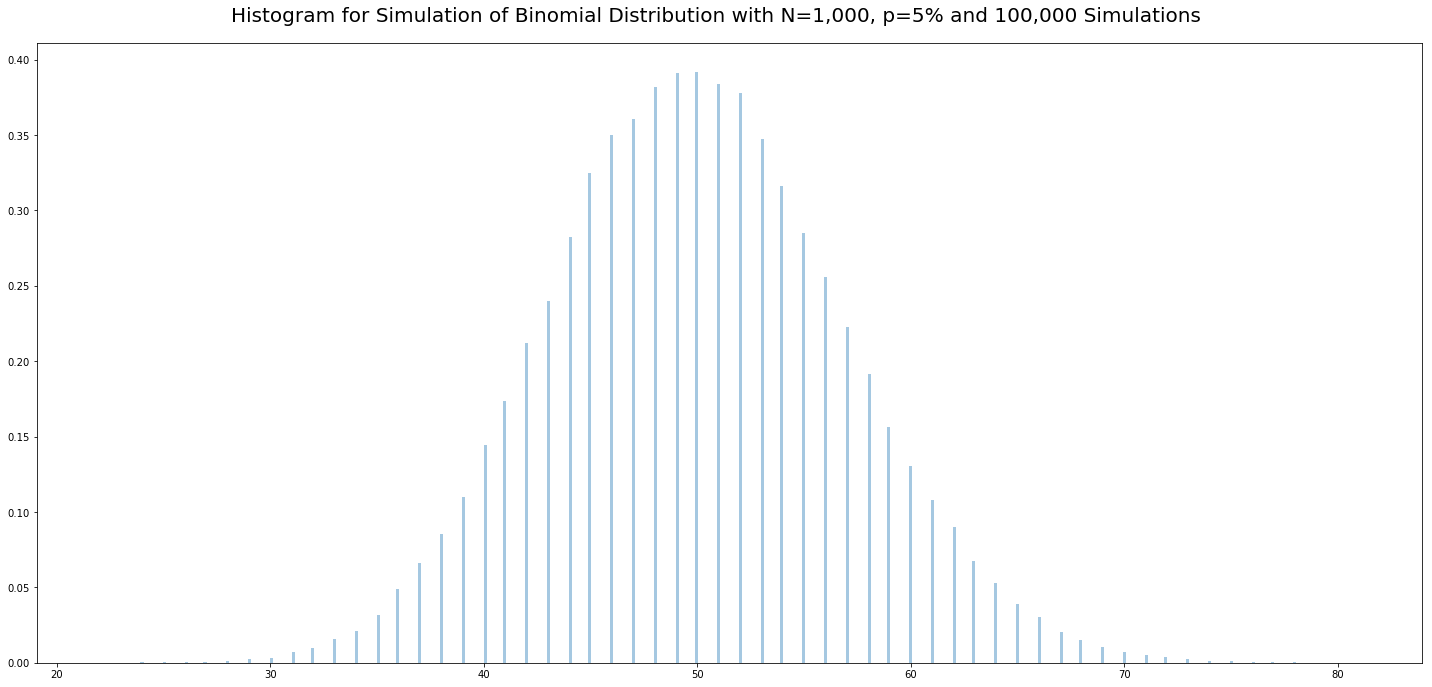

In [5]:
np.random.seed(seed=12345)
binom_sim = binom.rvs(1000, 0.05, size=100000)
print("Simulated Moments: Mean:{0:6.2f}, Variance:{1:6.2f}".format(np.mean(binom_sim),np.var(binom_sim)))

plt.figure(figsize=(20, 10))
sns.distplot(binom_sim,  kde=False, norm_hist=True, bins=400)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.suptitle('Histogram for Simulation of Binomial Distribution with N=1,000, p=5% and 100,000 Simulations',fontsize=20)

### One-Factor Merton Model:
Many popular credit risk models such as CreditMetrics use, as a starting point, the well-known [one-factor](https://en.wikipedia.org/wiki/Factor_analysis) Merton model which derives from Merton's [seminal paper](http://onlinelibrary.wiley.com/doi/10.1111/j.1540-6261.1974.tb03058.x/abstract) for modelling default events. These so-called asset value models is that one can derive the probability that a firm will default on its debt via option-pricing theory as such a default will occur once the firm asset values fall below a threshold defined by its obligations. 
These so-called asset value models basically state that one can derive the probability that a firm will default on its debt via option-pricing theory. A default will occur once the firm asset values fall below a threshold defined by its obligations. This is the same as saying that a default event takes place if a firms standardized asset returns $R_i$ fall below a firm specific default-threshold, $c_i$:

$$PD_i = \mathbb{P}(D_i=1) = \mathbb{P}(R_{i} < c_i)$$
 

As in the Black-Scholes-Merton model it is assumed that the asset returns follow a standard normal distribution. 
It is assumed that the standardized asset return of debtor $i$ is determined by a common macroeconomic factor $M$ as well as an idiosyncratic shock $U$. We assume that both the common factor and the idiosyncratic term are standard normally distributed: $M \sim \mathcal{N}(0,1) \text{ and } U \sim \mathcal{N}(0,1)$. Thus, $R_i$ follows a standard normal distribution as well.


$$R_{i} = \sqrt{\rho}\cdot M + \sqrt{(1-\rho)}\cdot U_{i} \sim \mathcal{N}(0,1)$$

In this way, one can simulate creditor defaults by drawing from a normal distribution. See the plot below for an illustration of the asset return distribution:

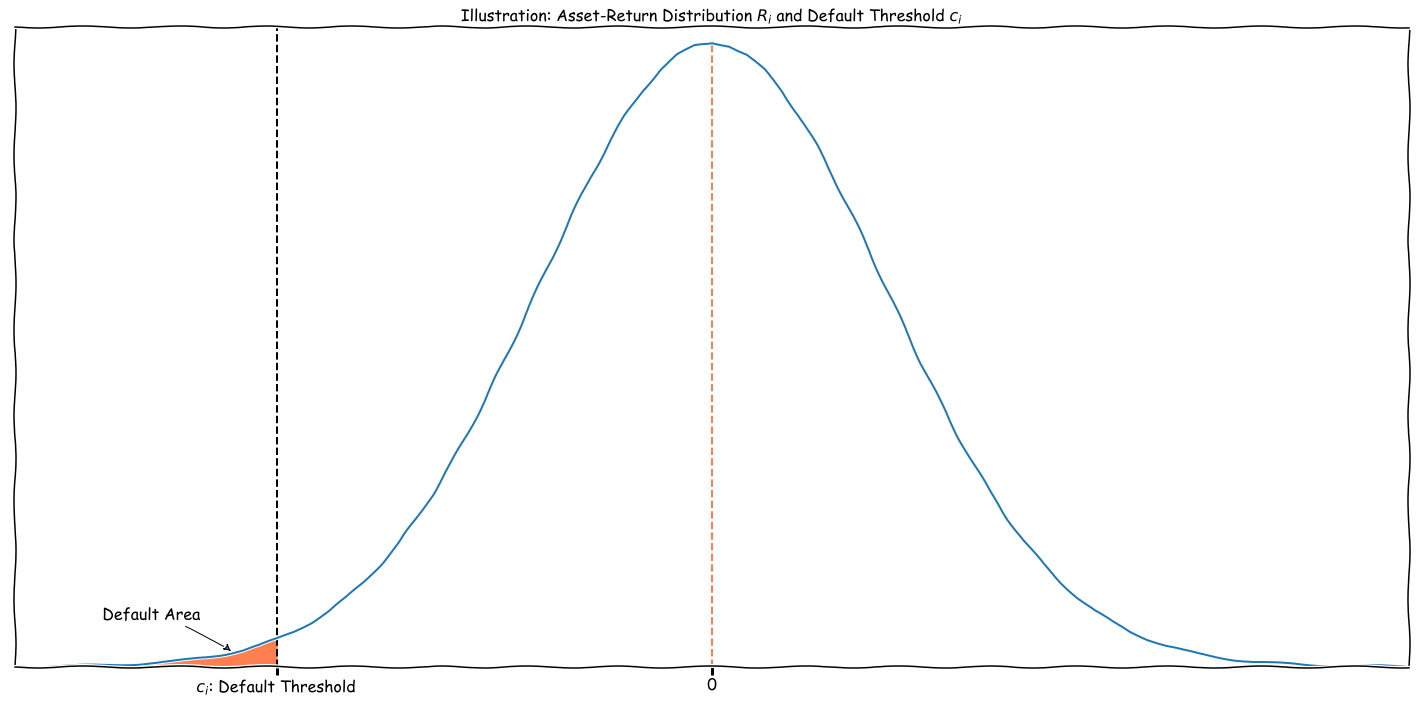

In [6]:
plt.figure(figsize=(20, 10))

#https://matplotlib.org/users/colors.html
#matplotlib.style.use('seaborn')
plt.xkcd()

x=np.arange(-4,4.1,0.1)
pdf =stats.norm.pdf(x)
plt.plot(x,pdf)

plt.vlines(x=0, ymin=0,ymax=stats.norm.pdf(0),linewidths=2, linestyle='--', color="coral")
plt.vlines(x=-2.5, ymin=0, ymax=1, linewidths=2, linestyle='--', color='k')

plt.annotate('Default Area',xy=(-2.75,stats.norm.pdf(-2.75)), xytext=(-3.5, 0.03),fontsize=16,  
             arrowprops =dict(arrowstyle="-|>", connectionstyle="arc3,rad=-0.1"))

plt.fill_between(x,pdf,where=x < -2.49,color='coral')
plt.xticks([-2.5,0],[r"$c_i$: Default Threshold","0"],fontsize=16)
plt.yticks([])
plt.ylim((0,stats.norm.pdf(0)+0.01))
plt.xlim((-4,4))
plt.title(r"Illustration: Asset-Return Distribution $R_i$ and Default Threshold $c_i$",fontsize=16)
plt.tight_layout()
plt.show()

In the formula for $R_i$, $\rho$ denotes the correlation-coefficient and $\sqrt{\rho}$ is often considered as the factor loading of the macroeconomy. It determines how skewed the portfolio loss distribution will be. The higher the correlation with the common macroeconomic factor, the more creditors will default at the same time in a rezession. This in turn will lead to a fatter right tail of the distribution with much higher higher portfolio losses at higher quantiles. The expected loss of the distribution is not affected by the degree of correlation in the portfolio. 

The PD of creditor $i$ thus depends on the state of the economy in the form of the realization of the common factor $M=m$. We can write it hence as:

$$PD_i(m) = \mathbb{P}(R_{i} < c_i|M=m)= \mathbb{P}(\sqrt{\rho} \cdot m + \sqrt{(1-\rho)} \cdot U_i < c_i) = P \left(U_{i} < \frac{c_i-\sqrt{\rho}\cdot m}{\sqrt{(1-\rho)}}\right) = \Phi\left(\frac{\Phi^{-1}(PD_i)-\sqrt{\rho}\cdot m}{\sqrt{(1-\rho)}}\right)$$

One crucial assumption of such a factor model is that dependencies between individual borrowers is solely due to the common macroeconomic factor. Conditional on the realization of $M$ creditors are independent of each other. Because of this conditional independence assumption, one can continue calculating default probabilties analogous to before. The probabilty of a certain number of defaults in the portfolio, conditional on a given realization of $M$ is written as:

$$\mathbb{P}\left(\sum_{i=1}^N D_i = k | M = m \right)  =  \binom{N}{k} \Phi\left(\frac{c_i-\sqrt{\rho}\cdot m}{\sqrt{(1-\rho)}}\right)^k \left(1-\Phi\left(\frac{c_i-\sqrt{\rho}\cdot m}{\sqrt{(1-\rho)}}\right)\right)^{N-k}$$

We can also calculate the unconditional PD by integrating over the distribution of the common factor:

$$\mathbb{P}\left(\sum_{i=1}^N D_i = k \right)  =  \binom{N}{k} \int^{+\infty}_{-\infty} \Phi\left(\frac{c_i-\sqrt{\rho}\cdot m}{\sqrt{(1-\rho)}}\right)^k \left(1-\Phi\left(\frac{c_i-\sqrt{\rho}\cdot m}{\sqrt{(1-\rho)}}\right)\right)^{N-k} \cdot \phi(m)dm$$

One way to calculate such a risk measure is via Monte Carlo integration. Here one draws $S$ independent realizations from the underlying distribution of $M$ ($m_1$, $m_2$, $\dots$, $m_S$) ,plugs them into the function under consideration and averages the resulting values:

$$\mathbb{P}\left(\sum_{i=1}^N D_i = k \right)  =  \binom{N}{k} \frac{1}{S}\sum^{S}_{s=1} \Phi\left(\frac{c_i-\sqrt{\rho}\cdot m_s}{\sqrt{(1-\rho)}}\right)^k \left(1-\Phi\left(\frac{c_i-\sqrt{\rho}\cdot m_s}{\sqrt{(1-\rho)}}\right)\right)^{N-k} $$


### Simulating a One-Factor Merton Model:
The examples in the rest of the notebook are based on credit portfolios consisting of 1,000 borrowers and models with 100,000 simulations. We will work with the same realizations of the common factor $M$ and the idiosyncratic factor $U$ which we draw here:

In [7]:
N_Creditors   = 1000
N_Simulations = 100000

#Matrix with uniformly distributed idiosyncratic erros (N_Sim x N_Creditors)
U = np.random.random(size=[N_Simulations,N_Creditors])
#Matrix with normally distributed common factors (N_Sim x 1)
M = np.random.normal(size=N_Simulations)

In [8]:
print("Shape of U: {0:,} x {1:,}; Shape of M:{2:,} x 1".format(U.shape[0],U.shape[1],M.shape[0]))

Shape of U: 100,000 x 1,000; Shape of M:100,000 x 1


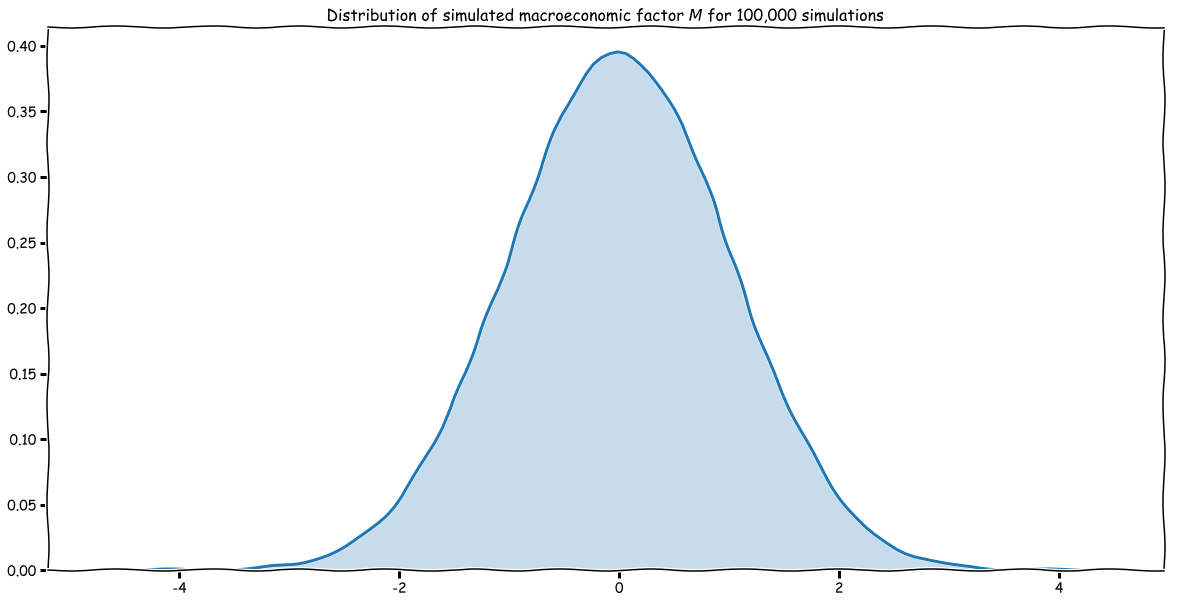

In [9]:
with plt.xkcd():
    plt.figure(figsize=(20, 10))
    sns.distplot(M,hist=False,  kde_kws = {'shade': True, 'linewidth': 3})
    plt.title(r"Distribution of simulated macroeconomic factor $M$ for 100,000 simulations",fontsize=16)

For the computation of the portfolio losses, we first generate a `Pandas` `DataFrame` with 1,000 identical entries with three different PD levels ranging from 2% to 6%:

In [10]:
#DataFrame with PD={2%,4%,6%}, LGD=100% and EaD=1 Euro
df = pd.DataFrame({
        "PD2" : [0.02 for i in range(N_Creditors)],
        "PD4" : 0.04,
        "PD6" : 0.06,
        "EAD" : 1,
        "LGD" : 1})
#Convert DataFrame to Numpy-Matrix for matrix-computations
df_mat = df.as_matrix()

df.head()

,EAD,LGD,PD2,PD4,PD6
0,1,1,0.02,0.04,0.06
1,1,1,0.02,0.04,0.06
2,1,1,0.02,0.04,0.06
3,1,1,0.02,0.04,0.06
4,1,1,0.02,0.04,0.06


Then, we can calculate the analytical expected loss as before by element-wise multiplication of the respective columns and adding up all the rows:

In [11]:
"Expected Loss for PD=2%:{0:6.2f}, PD=4%:{1:6.2f} and PD=6%:{2:6.2f}".format(
                                                                      np.sum(df_mat[:,0]*df_mat[:,1]*df_mat[:,2]),
                                                                      np.sum(df_mat[:,0]*df_mat[:,1]*df_mat[:,3]),
                                                                      np.sum(df_mat[:,0]*df_mat[:,1]*df_mat[:,4]))

'Expected Loss for PD=2%: 20.00, PD=4%: 40.00 and PD=6%: 60.00'

### Simulation with independent default-events:

For now, we will will assume that individual asset returns are uncorrelated, i.e. $\rho(R_i,R_j)=0$ $\forall i \neq j$. 

Here we tread a creditor $i$ as defaulted if the realization of its idiosyncratic effect for simulation $s$, $u_{is}$ is smaller than the individual probability of default $PD_i$. We then multiply the columns for LGD, EaD and simulated defaults and sum over all individuals. This result in 100,000 simulated portfolio losses per PD-level.

In [12]:
#Loss-DataFrame for each PD-level - results in N_Simulations simulated portfolio losses
df_loss = pd.DataFrame({
        "Loss2" : np.sum(df_mat[:,0]*df_mat[:,1]*(df_mat[:,2] > U).astype(int),axis=1),
        "Loss4" : np.sum(df_mat[:,0]*df_mat[:,1]*(df_mat[:,3] > U).astype(int),axis=1),
        "Loss6" : np.sum(df_mat[:,0]*df_mat[:,1]*(df_mat[:,4] > U).astype(int),axis=1)})
df_loss.describe()

,Loss2,Loss4,Loss6
count,100000.00,100000.00,100000.00
mean,19.97,39.99,59.99
std,4.44,6.20,7.50
min,4.00,15.00,31.00
25%,17.00,36.00,55.00
50%,20.00,40.00,60.00
75%,23.00,44.00,65.00
max,40.00,69.00,94.00


One can verify from the summary statistics above that the moments of the resulting loss distributions are as expected. 

Furthermore, the loss distributions exhibit the expected bell shape:

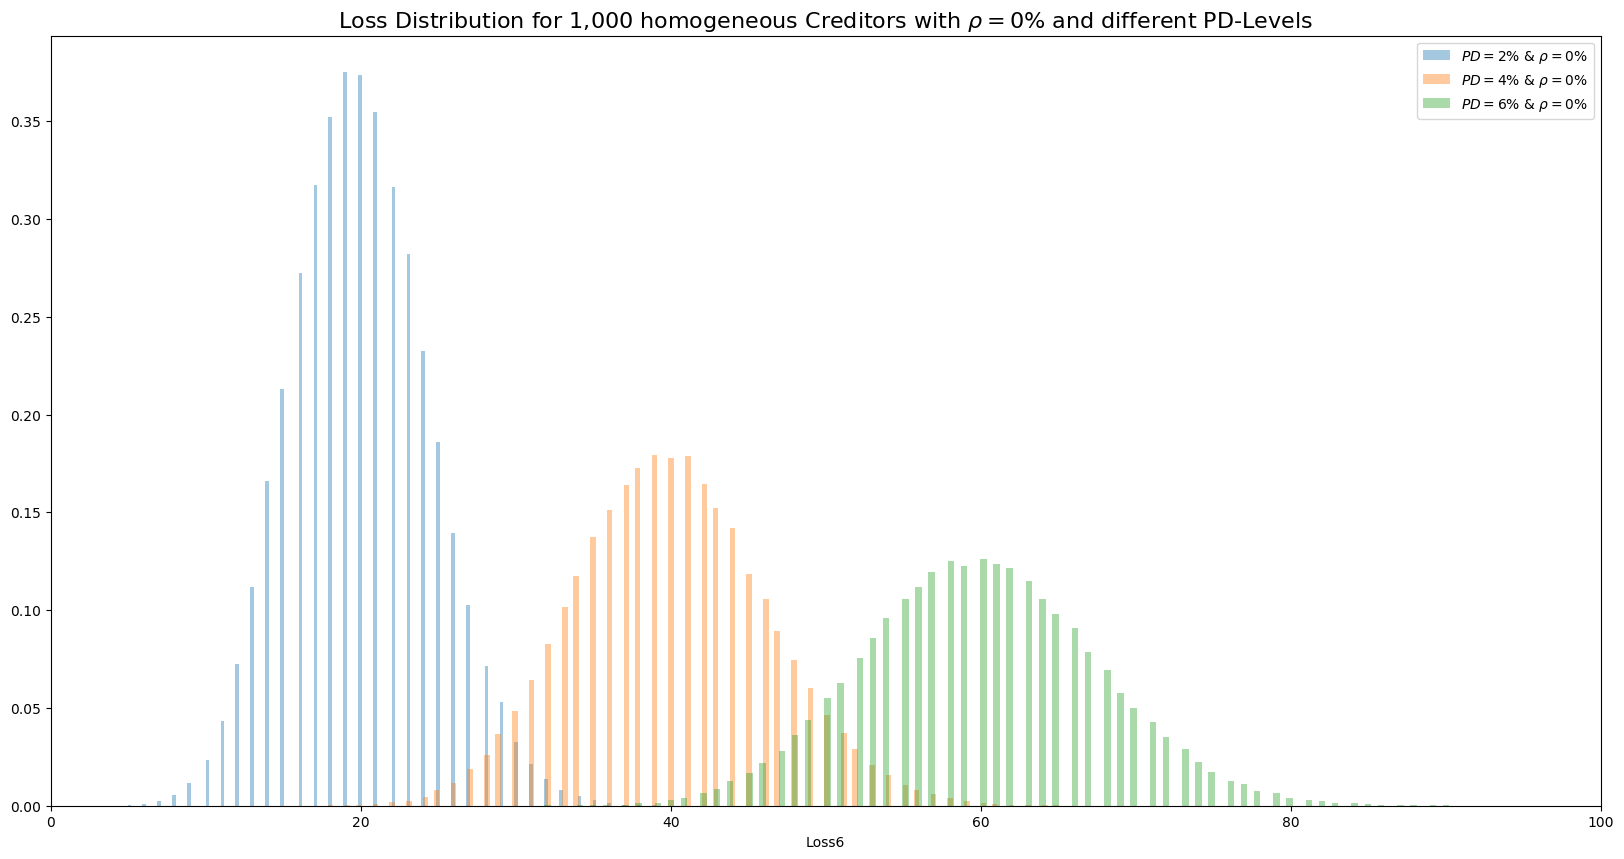

In [13]:
#Plot Histograms:
matplotlib.style.use('default')
plt.figure(figsize=(20, 10))

sns.distplot(df_loss["Loss2"],kde=False, norm_hist=True, bins=150, label=r'$PD=2\%$ & $\rho =0\%$')
sns.distplot(df_loss["Loss4"],kde=False, norm_hist=True, bins=150, label=r'$PD=4\%$ & $\rho =0\%$')
sns.distplot(df_loss["Loss6"],kde=False, norm_hist=True, bins=150, label=r'$PD=6\%$ & $\rho =0\%$')

plt.title(r"Loss Distribution for 1,000 homogeneous Creditors with $\rho =0\%$ and different PD-Levels",fontsize=16)
plt.xlim(0, 100)
plt.legend()
plt.show()

### Simulation with correlated asset-returns:

Next, we consider the more interesting case when individual returns are correlated with the common macroeconomic factor $M$. For this example we assume that $\rho = 10\%$. We can simulate the loss distribution by employing the formula for the conditional probability of default from above:

$PD_i(m) =  \Phi\left(\frac{\Phi^{-1}(PD_i)-\sqrt{\rho}\cdot m}{\sqrt{(1-\rho)}}\right)$


In [14]:
roh = 0.1

#PD = 2%
pd_m = norm.cdf((norm.ppf(df_mat[:,2]) - np.sqrt(roh)*M.reshape(N_Simulations,1))/np.sqrt(1-roh))
df_loss = pd.DataFrame({"Loss2" : np.sum(df_mat[:,0]*df_mat[:,1]*(pd_m > U).astype(int),axis=1)})
#PD = 4%
pd_m = norm.cdf((norm.ppf(df_mat[:,3]) - np.sqrt(roh)*M.reshape(N_Simulations,1))/np.sqrt(1-roh))
df_loss["Loss4"] = np.sum(df_mat[:,0]*df_mat[:,1]*(pd_m > U).astype(int),axis=1)
#PD = 6%                        
pd_m = norm.cdf((norm.ppf(df_mat[:,4]) - np.sqrt(roh)*M.reshape(N_Simulations,1))/np.sqrt(1-roh))
df_loss["Loss6"] = np.sum(df_mat[:,0]*df_mat[:,1]*(pd_m > U).astype(int),axis=1)                      
                        
df_loss.describe()

,Loss2,Loss4,Loss6
count,100000.00,100000.00,100000.00
mean,19.89,39.84,59.75
std,17.42,29.84,40.43
min,0.00,0.00,0.00
25%,8.00,19.00,30.00
50%,15.00,32.00,50.00
75%,26.00,53.00,79.00
max,236.00,354.00,423.00


As we can see, the expected portfolio loss for each PD-level is unchanged. However, the variation of the distribution is much higher, as can be seen by the standard deviations of the distributions, which are 4 to 5 times higher than for their uncorrelated counterparts. Furthermore, the tails of the distributions are much fatter as is indicated by the considerably higher maximum losses for each distribution. 

It helps to visualize the distributions again to get a better grasp of the effect of the correlation:

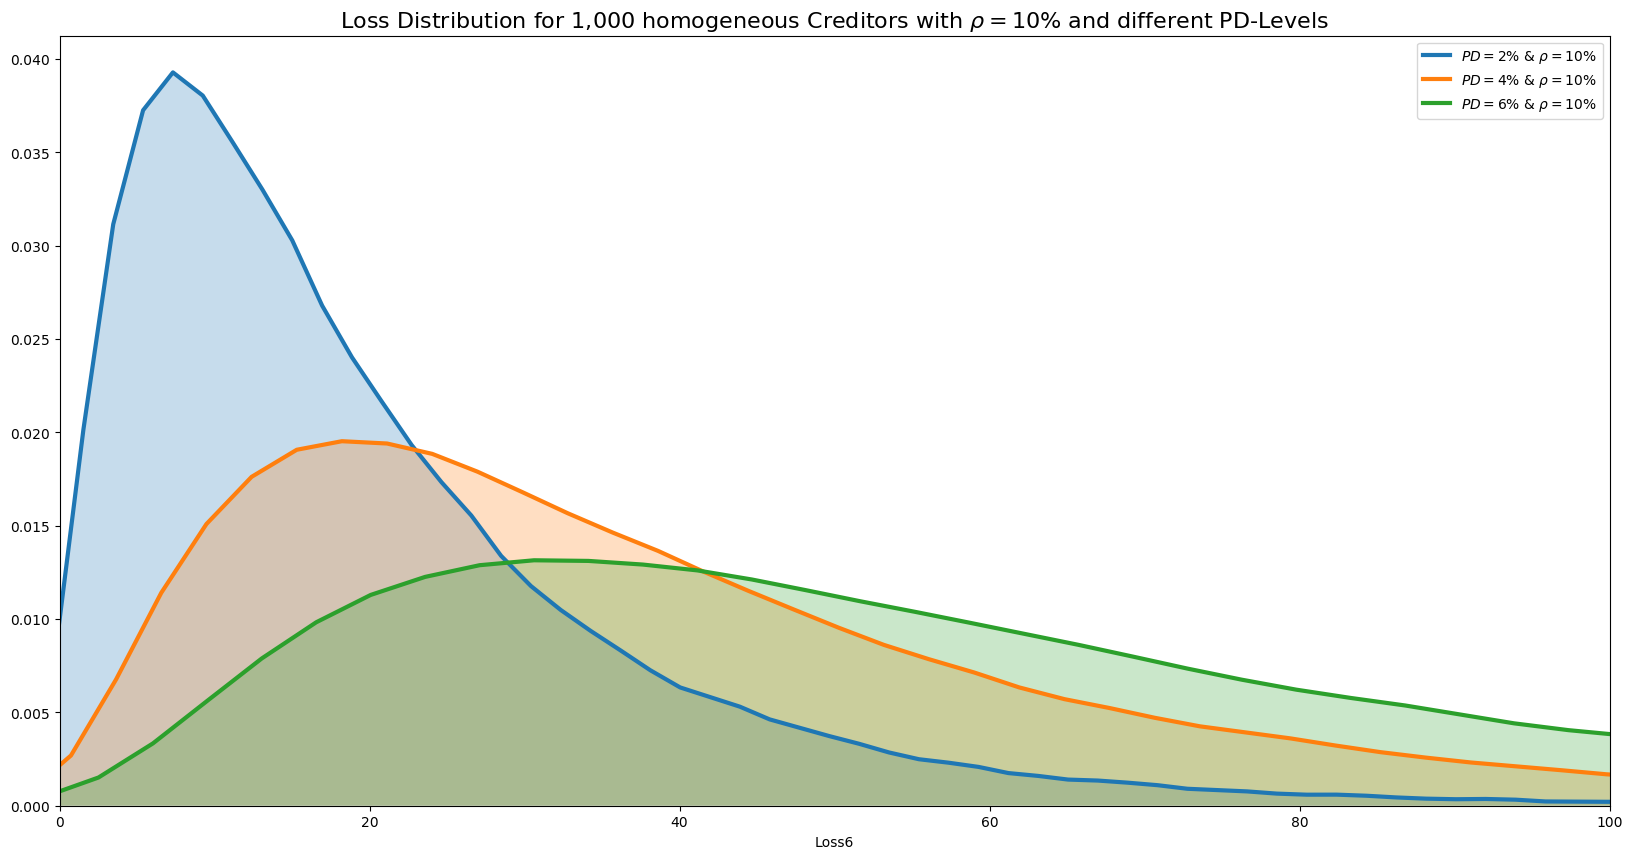

In [15]:
plt.figure(figsize=(20, 10))

sns.distplot(df_loss["Loss2"],hist=False,  kde_kws = {'shade': True, 'linewidth': 3}, label=r'$PD=2\%$ & $\rho =10\%$')
sns.distplot(df_loss["Loss4"],hist=False,  kde_kws = {'shade': True, 'linewidth': 3}, label=r'$PD=4\%$ & $\rho =10\%$')
sns.distplot(df_loss["Loss6"],hist=False,  kde_kws = {'shade': True, 'linewidth': 3}, label=r'$PD=6\%$ & $\rho =10\%$')

plt.title(r"Loss Distribution for 1,000 homogeneous Creditors with $\rho =10\%$ and different PD-Levels",fontsize=16)
plt.xlim(0, 100)
plt.legend()
plt.show()

It is obvious that little of the bell shaped form is left. Instead, the distributions are much more spread out with a considerable skew and fat tail.

### Effect of different levels of correlation for the same PD:
Likewise we can observe the effect of different levels of $\rho$ for a fixed PD value (4%). This gives one a good idea about how the distribution becomes more and more fat-tailed as the $\rho$-level increases:

In [16]:
#Rho=0%
pd_m = norm.cdf((norm.ppf(df_mat[:,3]) - np.sqrt(0)*M.reshape(N_Simulations,1))/np.sqrt(1-0))
df_loss = pd.DataFrame({"Loss0" : np.sum(df_mat[:,0]*df_mat[:,1]*(pd_m > U).astype(int),axis=1)})
#Rho=10%
pd_m = norm.cdf((norm.ppf(df_mat[:,3]) - np.sqrt(0.1)*M.reshape(N_Simulations,1))/np.sqrt(1-0.1))
df_loss["Loss10"] = np.sum(df_mat[:,0]*df_mat[:,1]*(pd_m > U).astype(int),axis=1)
#Rho=20%                     
pd_m = norm.cdf((norm.ppf(df_mat[:,3]) - np.sqrt(0.2)*M.reshape(N_Simulations,1))/np.sqrt(1-0.2))
df_loss["Loss20"] = np.sum(df_mat[:,0]*df_mat[:,1]*(pd_m > U).astype(int),axis=1)                      

df_loss.describe()

,Loss0,Loss10,Loss20
count,100000.00,100000.00,100000.00
mean,39.99,39.84,39.76
std,6.20,29.84,44.60
min,15.00,0.00,0.00
25%,36.00,19.00,10.00
50%,40.00,32.00,25.00
75%,44.00,53.00,53.00
max,69.00,354.00,594.00


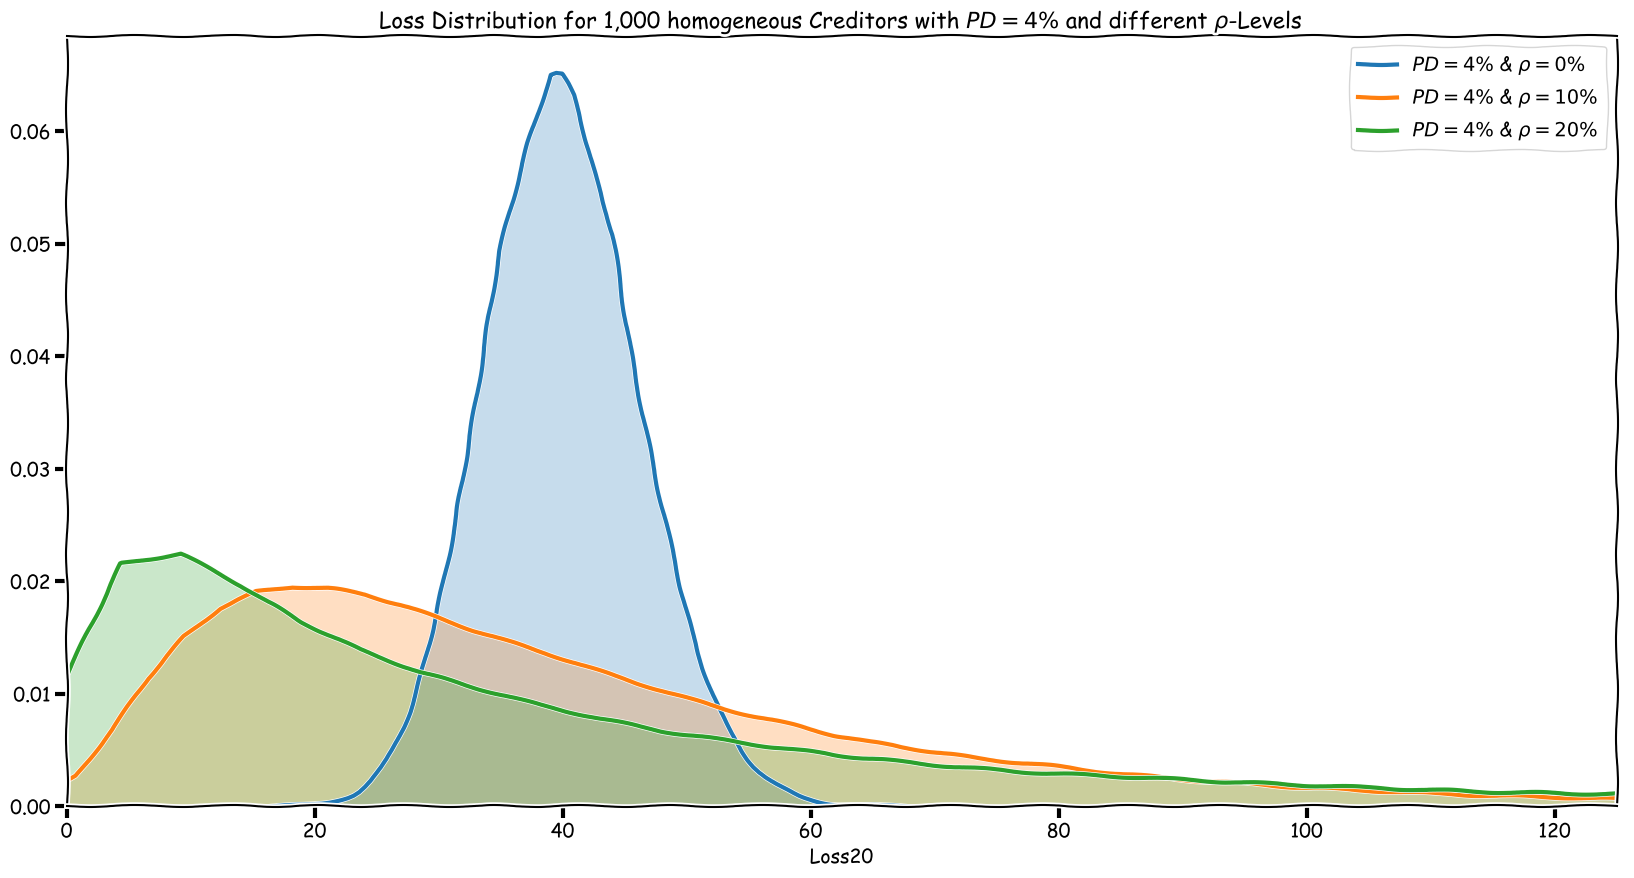

In [17]:
plt.xkcd()
plt.figure(figsize=(20, 10))

sns.distplot(df_loss["Loss0"] ,hist=False,  kde_kws = {'shade': True, 'linewidth': 3}, label=r'$PD=4\%$ & $\rho =0\%$')
sns.distplot(df_loss["Loss10"],hist=False, kde_kws = {'shade': True, 'linewidth': 3}, label=r'$PD=4\%$ & $\rho =10\%$')
sns.distplot(df_loss["Loss20"],hist=False, kde_kws = {'shade': True, 'linewidth': 3}, label=r'$PD=4\%$ & $\rho =20\%$')

plt.title(r"Loss Distribution for 1,000 homogeneous Creditors with $PD =4\%$ and different $\rho$-Levels",fontsize=16)
plt.xlim(0, 125)
plt.legend()
plt.show()

### Heterogenous Portfolio & Sector-Specific Correlations:

Next, we will consider a somewhat more realistic szenario by allowing the risk parameters to differ between creditors. For this purpose we sample the PDs from four different levels. The EaD (expressed in million Euros) lies uniformly between 100,000 and 100 Mio. Euro, while the LGD follows a Beta distribution with mean 50%. Finally, creditors can belong to one of four different costumer segements: Banks, Corporates, Real Estate and Retail.

In [18]:
df = pd.DataFrame({
        "Segment" : np.random.choice(["Corporate", "Real Estate", "Bank", "Retail"] , 
                                     N_Creditors, p=[0.5, 0.3, 0.1, 0.1]),
        "PD"  : np.random.choice([0.005, 0.02, 0.05, 0.15], N_Creditors, p=[0.3, 0.4, 0.15, 0.15]),
        "EAD" : np.random.uniform(0.1,100,N_Creditors).astype(int),
        "LGD" : np.random.beta(a=5, b=5, size=N_Creditors)})
df.head()

,EAD,LGD,PD,Segment
0,58,0.35,0.15,Corporate
1,82,0.61,0.02,Retail
2,0,0.64,0.01,Corporate
3,33,0.45,0.15,Corporate
4,60,0.40,0.01,Corporate


In [19]:
df.describe()

,EAD,LGD,PD
count,1000.00,1000.00,1000.00
mean,49.47,0.49,0.04
std,28.33,0.15,0.05
min,0.00,0.09,0.01
25%,26.00,0.39,0.01
50%,48.00,0.49,0.02
75%,74.00,0.60,0.05
max,99.00,0.88,0.15


It is most illustrative to plot the distributions of the risk parameters along with that of the expected loss:

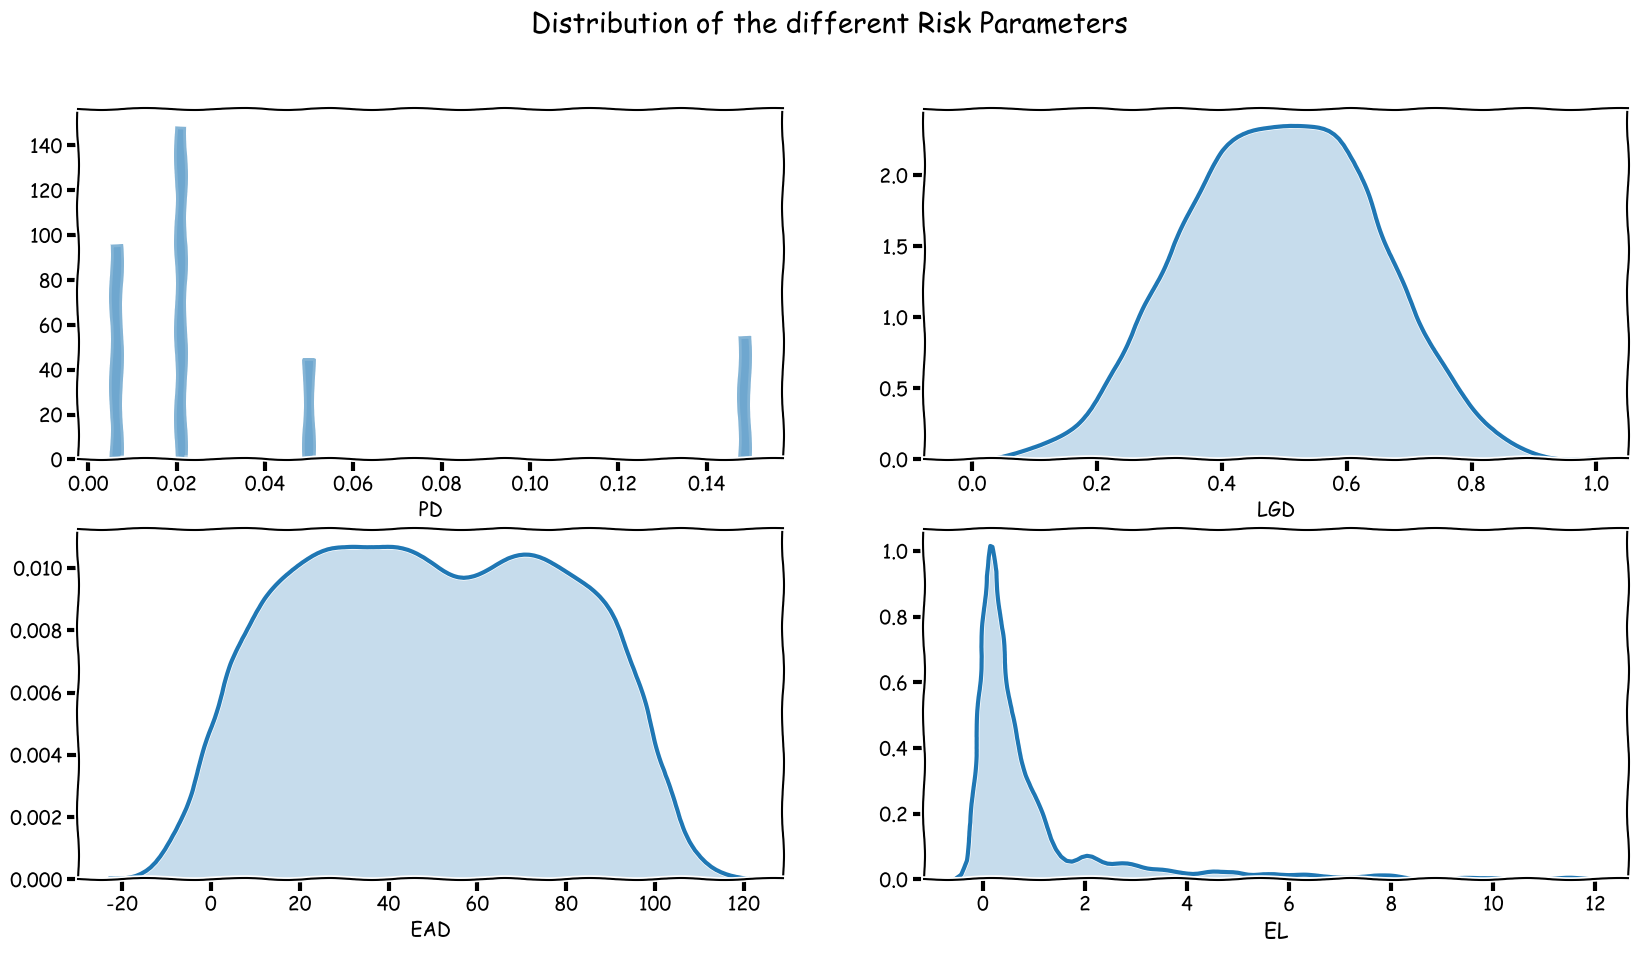

In [20]:
plt.figure(figsize=(20, 10))

plt.subplot(221)
sns.distplot(df["PD"],kde=False, norm_hist=True, bins=50)

plt.subplot(222)
sns.distplot(df["LGD"],hist=False,  kde_kws = {'shade': True, 'linewidth': 3})

plt.subplot(223)
sns.distplot(df["EAD"],hist=False,  kde_kws = {'shade': True, 'linewidth': 3})

plt.subplot(224)
sns.distplot(df["PD"]*df["LGD"]*df["EAD"],hist=False,  kde_kws = {'shade': True, 'linewidth': 3})
plt.xlabel('EL',fontsize=15)

plt.suptitle('Distribution of the different Risk Parameters',fontsize=20)

So far we have assumed that all creditors are affected to the same extend by the common macroeconomic factor. However, it makes sense to assume that different sectors of the economy exhibit different degrees of dependency to the overall economic situation. To incorporate this consideration, we let the correlation coefficient differ between the segments:

$PD_{i,k}(m) = \Phi\left(\frac{\Phi^{-1}(PD_i)-\sqrt{\rho_k}\cdot m}{\sqrt{(1-\rho_k)}}\right)$

Here, we merge different $\rho$ values via the Segment column:

In [21]:
df_corr = pd.DataFrame({
        "Segment_ID" : [0, 1, 2, 3], 
        "Segment" : ["Bank", "Corporate", "Real Estate", "Retail"],
        "Rho" : [0.3, 0.2, 0.15, 0.05]})
df_corr=df_corr[["Segment_ID","Segment","Rho"]]
df_corr.head()

,Segment_ID,Segment,Rho
0,0,Bank,0.30
1,1,Corporate,0.20
2,2,Real Estate,0.15
3,3,Retail,0.05


In [22]:
df = df.merge(df_corr, on='Segment')
df=df[["PD","LGD","EAD","Rho","Segment_ID","Segment"]]
df.head()

,PD,LGD,EAD,Rho,Segment_ID,Segment
0,0.15,0.35,58,0.20,1,Corporate
1,0.01,0.64,0,0.20,1,Corporate
2,0.15,0.45,33,0.20,1,Corporate
3,0.01,0.40,60,0.20,1,Corporate
4,0.02,0.32,82,0.20,1,Corporate


In [23]:
df_mat = df.as_matrix()
df_mat[1:20,:]

array([[0.005, 0.6369229811483689, 0, 0.2, 1, 'Corporate'],
       [0.15, 0.4467739477673906, 33, 0.2, 1, 'Corporate'],
       [0.005, 0.3970104995607381, 60, 0.2, 1, 'Corporate'],
       [0.02, 0.3153823274071043, 82, 0.2, 1, 'Corporate'],
       [0.05, 0.35990229809212576, 78, 0.2, 1, 'Corporate'],
       [0.05, 0.37459613002448644, 60, 0.2, 1, 'Corporate'],
       [0.02, 0.7027143039657844, 83, 0.2, 1, 'Corporate'],
       [0.05, 0.4212405490371853, 37, 0.2, 1, 'Corporate'],
       [0.02, 0.5660272177531154, 56, 0.2, 1, 'Corporate'],
       [0.02, 0.7432525946564889, 2, 0.2, 1, 'Corporate'],
       [0.02, 0.3520918278032381, 24, 0.2, 1, 'Corporate'],
       [0.02, 0.23179603833811122, 65, 0.2, 1, 'Corporate'],
       [0.15, 0.2593537960677457, 11, 0.2, 1, 'Corporate'],
       [0.15, 0.3912813528863576, 96, 0.2, 1, 'Corporate'],
       [0.02, 0.36702045508375986, 82, 0.2, 1, 'Corporate'],
       [0.005, 0.2849104210630364, 34, 0.2, 1, 'Corporate'],
       [0.005, 0.6051947722494965, 

In [24]:
"Expected Loss for the distribution:{0:6.2f}".format(np.sum(df_mat[:,0]*df_mat[:,1]*df_mat[:,2]))

'Expected Loss for the distribution:1000.30'

In [25]:
pd_m = norm.cdf((norm.ppf(list(df_mat[:,0])) - np.sqrt(list(df_mat[:,3]))*M.reshape(N_Simulations,1))/np.sqrt(list(1-df_mat[:,3])))
df_loss = pd.DataFrame({"Loss" : np.sum(df_mat[:,1]*df_mat[:,2]*(pd_m > U).astype(int),axis=1).astype(np.float) })
df_loss.describe()

,Loss
count,100000.00
mean,994.70
std,868.69
min,0.00
25%,396.68
50%,745.26
75%,1320.05
max,10887.73


We can use this example to illustrate a general point about the simulated distribution of portfolio losses. As we have seen, it is trivial to calculated the expected portfolio loss - provided one has reliable estimates of the risk parameters involved. 

As mentioned before, the more interesting metric it the unexpected loss. Often the so-called **Value at Risk** (VaR) is used as a measure for the UL. The VaR is simply a quantile of the loss distribution at a relatively high $\alpha$-level. Commonly an $\alpha$-level of 99% or higher is chosen. The value at risk is the minimum loss that will occur in the $(\alpha - 1)$ worst realizations. The VaR at the 99% for a one-year horizon is often interpreted as the (minimum) portfolio loss which will only occur once in a century. 

The difference between the expected and the unexpected loss is known as **Economic Capital** (EC). It can be understood as the capital buffer that is required to prevent a bankruptcy at a certain confidence level. 

The following graph illustrates these concepts for our hypothetical example:

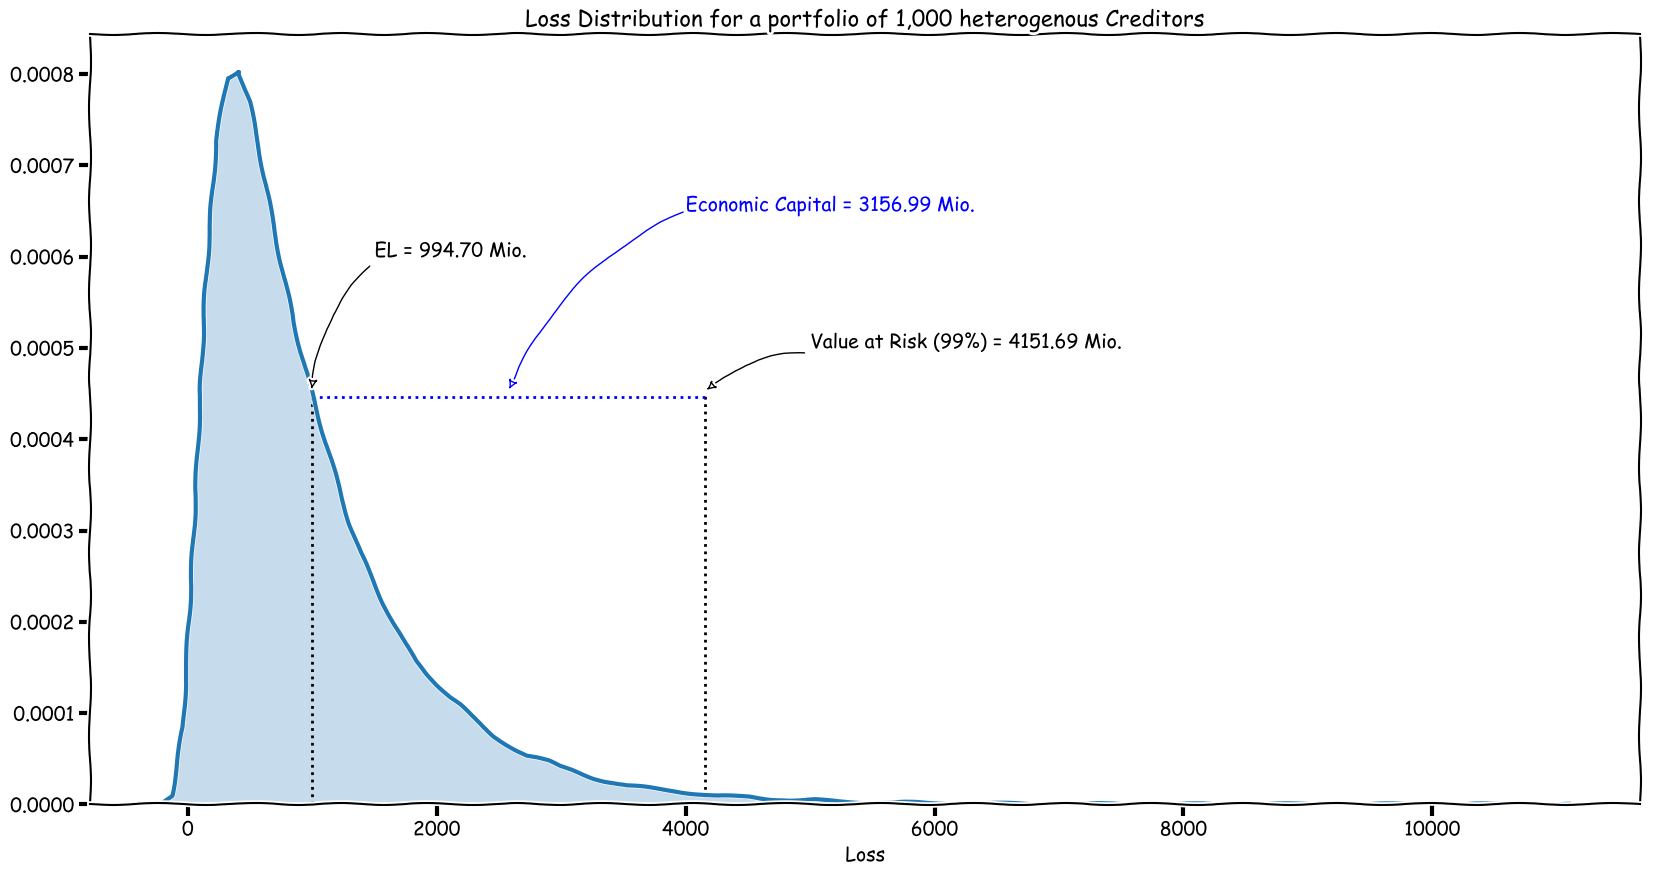

In [26]:
plt.figure(figsize=(20, 10))

Mean  = df_loss["Loss"].mean()
VaR99 = df_loss["Loss"].quantile(.99)
EC    = VaR99 - Mean

ax = sns.distplot(df_loss["Loss"],hist=False,kde_kws = {'shade': True, 'linewidth': 3})

data_x, data_y = ax.lines[0].get_data()
y_mean = np.interp(Mean,data_x, data_y)

plt.vlines(x=Mean, ymin=0, ymax=y_mean, 
           linewidths=2, linestyle='dotted', color="k")

plt.annotate("EL = {0:6.2f} Mio.".format(Mean),
             xy=(Mean, y_mean),  xytext=(1500, 0.0006), 
             arrowprops =dict(arrowstyle="-|>", connectionstyle="arc3,rad=0.2", relpos=(0, 0), fc="w"))

plt.vlines(x=VaR99, ymin=0, ymax=y_mean, 
           linewidths=2, linestyle='dotted', color="k")

plt.annotate("Value at Risk (99%) = {0:6.2f} Mio.".format(VaR99),
             xy=(VaR99, y_mean),  xytext=(5000, 0.0005), 
             arrowprops =dict(arrowstyle="-|>", connectionstyle="arc3,rad=0.2", relpos=(0, 0), fc="w"))

plt.hlines(y=y_mean-0.000005, xmin=Mean, xmax=VaR99, 
           linewidths=2,colors="blue", linestyles='dotted', label='')

plt.text(4000, 0.00065,"Economic Capital = {0:6.2f} Mio.".format(EC), color="blue")
plt.annotate("",
             xy=((VaR99+Mean)/2, y_mean),  xytext=(4000, 0.00065), 
             arrowprops =dict(arrowstyle="-|>", connectionstyle="arc3,rad=0.2", relpos=(0, 0), fc="w",
                              color="blue"))

plt.title(r"Loss Distribution for a portfolio of 1,000 heterogenous Creditors",fontsize=16)

### Intersectoral Correlations
In the last example we allowed the so-called intrasectoral correlation to differ, i.e. the correlation of individuals **within** a sector with the overall economy. We can go one step further, though, by explicitly incorporating the correlation **between** sectors. So far we implicitly assumed that the sectors are perfectly correlated. 

We can make the intersectoral dependencies explicit, by sampling individual realizations of $M$, i.e. $M_k$, for each sector. In this fashion, we get a multifactor model: 
$PD_{i,k}(m_k) = \Phi\left(\frac{\Phi^{-1}(PD_i)-\sqrt{\rho_k}\cdot m_k}{\sqrt{(1-\rho_k)}}\right)$

The individual $M_k$'s are drawn from a correlated multivariate normal distribution. First, we have to define the intersectoral correlation matrix:

In [27]:
inter_corr = np.matrix('1 0.8 0.6 0.2; 0.8 1 0.6 0.4; 0.6 0.6 1 0.4; 0.2 0.4 0.4 1') 
inter_corr

matrix([[1. , 0.8, 0.6, 0.2],
        [0.8, 1. , 0.6, 0.4],
        [0.6, 0.6, 1. , 0.4],
        [0.2, 0.4, 0.4, 1. ]])

Then we use it to generate correlated normal distributions:

In [28]:
corr_norm = np.random.multivariate_normal(mean=[0,0,0,0], cov=inter_corr, size=N_Simulations).T

Let's visualize the relationship between the different $M_k$ factors:

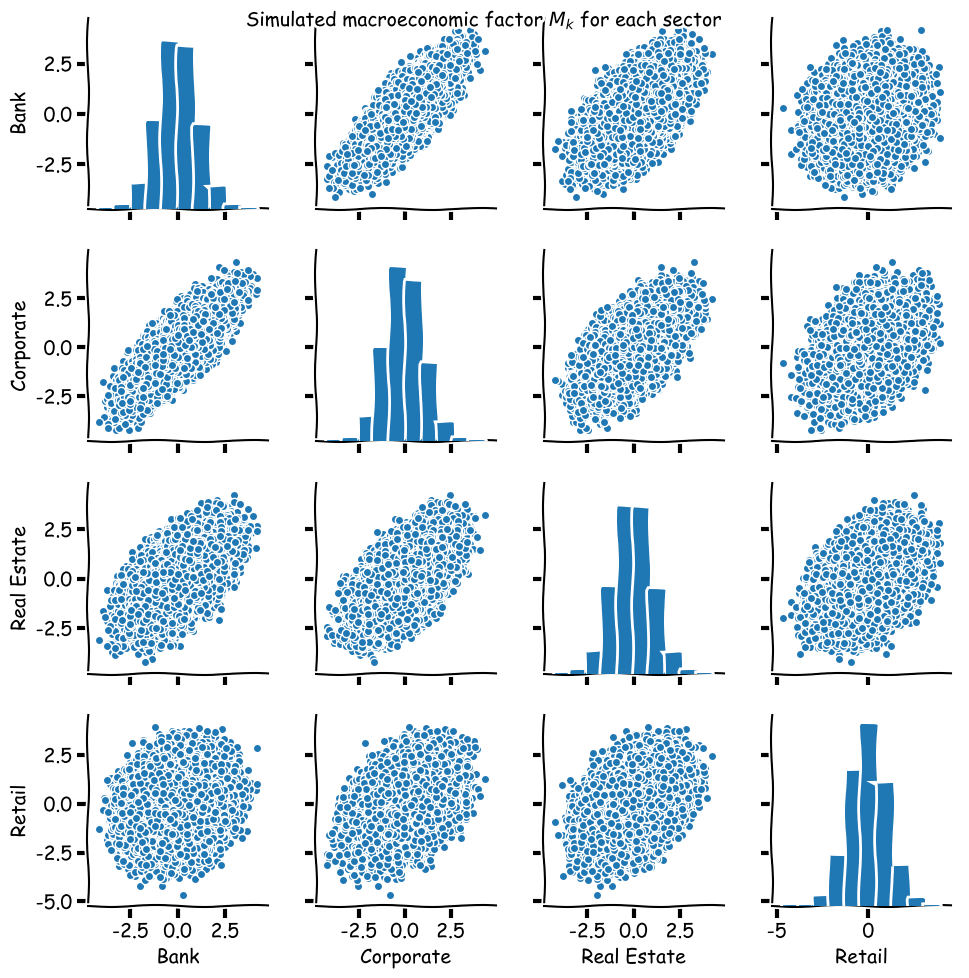

In [29]:
sns.pairplot(pd.DataFrame(corr_norm.T,columns=["Bank", "Corporate", "Real Estate", "Retail"]))
plt.suptitle(r"Simulated macroeconomic factor $M_k$ for each sector",fontsize=14)

Now let's simulate the loss distribution again and compare the results to previous case. Because the correlation between the segments is lower than in the one-factor-model, the tail of the distribution should be flatter.

We can sample the appropriate factor $M_k$ by indexing the simulated M-Factors with the column for the segment IDs from our data-matrix: ```corr_norm[df_mat[:,4].astype(int),:])```

In [30]:
pd_m = norm.cdf((norm.ppf(list(df_mat[:,0])) -(np.sqrt(list(df_mat[:,3])).reshape(N_Creditors,1)*corr_norm[df_mat[:,4].astype(int),:]).T)/np.sqrt(list(1-df_mat[:,3])))
df_loss = pd.DataFrame({"Loss" : np.sum(df_mat[:,1]*df_mat[:,2]*(pd_m > U).astype(int),axis=1).astype(np.float) })
df_loss.describe()

,Loss
count,100000.00
mean,1002.43
std,750.70
min,0.00
25%,476.70
50%,808.92
75%,1312.02
max,8496.06


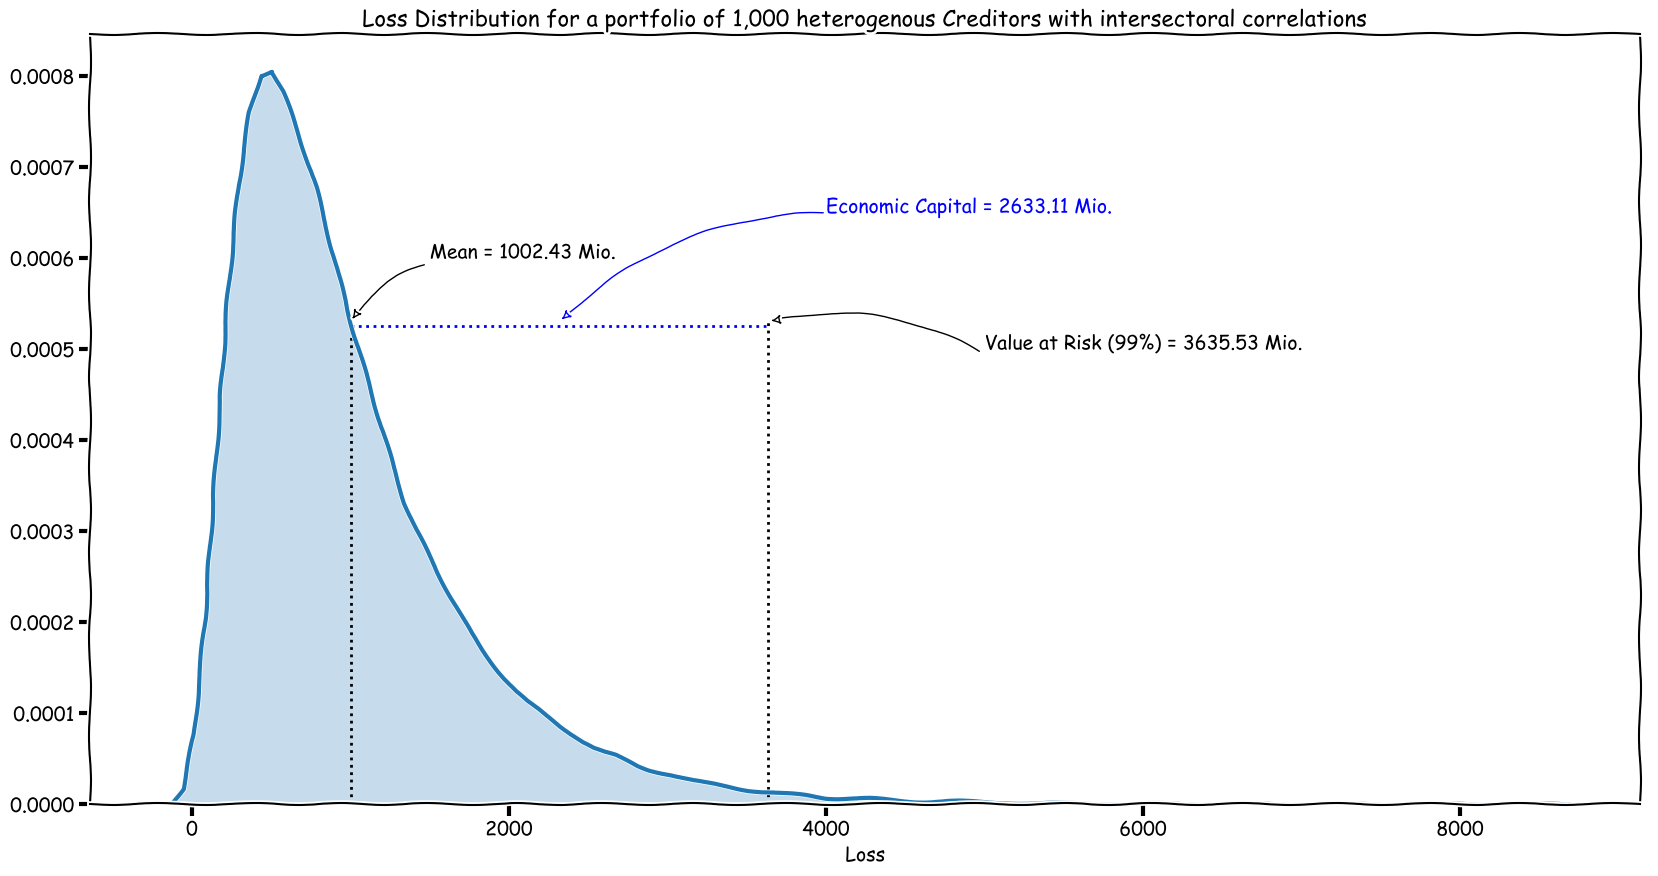

In [31]:
plt.figure(figsize=(20, 10))

Mean  = df_loss["Loss"].mean()
VaR99 = df_loss["Loss"].quantile(.99)
EC    = VaR99 - Mean

ax = sns.distplot(df_loss["Loss"],hist=False,kde_kws = {'shade': True, 'linewidth': 3})

data_x, data_y = ax.lines[0].get_data()
y_mean = np.interp(Mean,data_x, data_y)

plt.vlines(x=Mean, ymin=0, ymax=y_mean, 
           linewidths=2, linestyle='dotted', color="k")

plt.annotate("Mean = {0:6.2f} Mio.".format(Mean),
             xy=(Mean, y_mean),  xytext=(1500, 0.0006), 
             arrowprops =dict(arrowstyle="-|>", connectionstyle="arc3,rad=0.2", relpos=(0, 0), fc="w"))

plt.vlines(x=VaR99, ymin=0, ymax=y_mean, 
           linewidths=2, linestyle='dotted', color="k")

plt.annotate("Value at Risk (99%) = {0:6.2f} Mio.".format(VaR99),
             xy=(VaR99, y_mean),  xytext=(5000, 0.0005), 
             arrowprops =dict(arrowstyle="-|>", connectionstyle="arc3,rad=0.2", relpos=(0, 0), fc="w"))

plt.hlines(y=y_mean-0.000005, xmin=Mean, xmax=VaR99, 
           linewidths=2,colors="blue", linestyles='dotted', label='')

plt.text(4000, 0.00065,"Economic Capital = {0:6.2f} Mio.".format(EC), color="blue")
plt.annotate("",
             xy=((VaR99+Mean)/2, y_mean),  xytext=(4000, 0.00065), 
             arrowprops =dict(arrowstyle="-|>", connectionstyle="arc3,rad=0.2", relpos=(0, 0), fc="w",
                              color="blue"))
plt.title(r"Loss Distribution for a portfolio of 1,000 heterogenous Creditors with intersectoral correlations",fontsize=16)

As expected, the loss distributon is less skewed compared to the previous case where all segments were implicitly perfectly correlated.

### Final Remarks:

Hopefully this notebook has given the interested reader a good introduction to the basic operating principles of credit risk models. 

Of course the models presented here are quite simple. Production-level models incorporate many other important aspects of the loss distribution. A non-exhaustive list would entail:

 - LGD stochastics 
 - Migration risks (mark-to-market instead of default-mode)
 - Importance sampling techniques for a more stable estimation of the tail-risk
 - Correlations between PD and LGD parameters
